In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline
import pathlib

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

In [3]:
_save_dir = 'plots_compare/'

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    'gray',
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

In [4]:
path = f"/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields"

In [5]:
folders = pathlib.Path(path)
fileslist = []
folders_paths = list(folders.iterdir())
for folder in folders_paths:
    # Verifica se è una directory
    if folder.is_dir():
        # Costruisci il percorso del file da cercare
        target_file = folder / 'merged_sim_arcs_beamline_simple_'
        
        # Controlla se il file esiste
        if target_file.exists():
            fileslist.append(target_file)
        else:
            print(f"File non trovato in: {folder}")

# Output dei file trovati
print(f"File trovati: {fileslist}")

File non trovato in: /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.30
File trovati: [PosixPath('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.10/merged_sim_arcs_beamline_simple_'), PosixPath('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.40/merged_sim_arcs_beamline_simple_'), PosixPath('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.60/merged_sim_arcs_beamline_simple_'), PosixPath('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.70/merged_sim_arcs_beamline_simple_'), PosixPath('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.20/merged_sim_arcs_beamline_simple_'), PosixPath('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.50/merged_sim_arcs_be

Since there were some problems, we have to manually add two more files, that are in another location



In [6]:
fileslist.append('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/varying_fields/B0.30/merged_sim_arcs_beamline_simple_')
fileslist.append('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sims/config08/merged_sim_arcs_beamline_simple_')

In [7]:
print(fileslist[0], fileslist[-1])

/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.10/merged_sim_arcs_beamline_simple_ /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sims/config08/merged_sim_arcs_beamline_simple_


In [ ]:

import shutil

# Lista dei percorsi dei file da copiare


# Crea la nuova cartella se non esiste già
destination_dir = os.path.join(os.getcwd(), 'copies of merged files')
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Copia i file nella nuova cartella
for file_path in fileslist:
    try:
        shutil.copy(file_path, destination_dir)
        print(f"Copied {file_path} to {destination_dir}")
    except Exception as e:
        print


In [8]:
def find_field_fraction(stra, strb):
    stra, strb = str(stra), str(strb)
    if strb in stra:
        result = stra.replace(strb+'/B', '')
        if '/merged_sim_arcs_beamline_simple_' in result:
            result = result.replace('/merged_sim_arcs_beamline_simple_', '')
            
        return float(result)
    elif stra == '/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/varying_fields/B0.30/merged_sim_arcs_beamline_simple_':
        return .3
    elif stra == '/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sims/config08/merged_sim_arcs_beamline_simple_':
        return 1
    else:
        print('sorry i could not subtract these two strings!')
        print(stra)
        print(strb+'/B')
        return None

print(find_field_fraction('/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.05', path))

0.05


This is the second dodgy thing I am going to do in this code. I am coning to to add a list for the number of entries in each simulation. 
9959

In [9]:
n = [9990,9990,9991,9992, 9959,9937,9986,9717]

In [10]:
for i in fileslist:
    print(find_field_fraction( i, path))

0.1
0.4
0.6
0.7
0.2
0.5
0.3
1


In [11]:
print(fileslist[2])

/pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.60/merged_sim_arcs_beamline_simple_


In [38]:

def add_vars_to_df(df):
    px, py, pz = df['Px'], df['Py'], df['Pz']
    p = (px**2 + py**2 + pz**2)**0.5
    theta = np.arctan2((px**2 + py**2)**0.5, pz) / np.pi * 180
    phi = np.arctan2(py, px) / np.pi * 180
    df['P'] = p
    df['theta'] = theta
    df['phi'] = phi
    return df

def analyze_file_with_cut(file_path, p_min=0, p_max=40000, save = False):

    branches = ['x', 'y', 'z', 'Px', 'Py', 'Pz', 'PDGid', 'EventID', 'TrackID']

    #  file ROOT opening
    file = uproot.open(file_path)
    print(f'file {file_path} opened')

    if len(file.keys()) != 0:
        # Dataframes for Det7 and JGGDet1
        det7_df = file['VirtualDetector/Det7'].arrays(branches, library='pd')
        det7_df = det7_df.drop_duplicates(['EventID', 'TrackID'])
        
        jgg_df = file['VirtualDetector/JGGDet1'].arrays(branches, library='pd')
        jgg_df = jgg_df.drop_duplicates(['EventID', 'TrackID'])
        
        # Calculate 'P', 'theta', 'phi'
        print('file adjusted')
    
        
        det7_df = add_vars_to_df(det7_df)
        jgg_df = add_vars_to_df(jgg_df)
        
        # Cut on P momentum 
        det7_df = det7_df[(det7_df['P'] >= p_min) & (det7_df['P'] <= p_max)]
        jgg_df = jgg_df[(jgg_df['P'] >= p_min) & (jgg_df['P'] <= p_max)]
    
        
        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        fff = find_field_fraction( file_path, path)
        fig.suptitle(f'Field magnitude {fff*0.70:.2f} [T]')
        
        # Det7
        els7 = det7_df[det7_df.PDGid == 11]
        pos7 = det7_df[det7_df.PDGid == -11]

        axes[0].hist(els7['P'], bins=50, alpha=0.75, label=r'$e^{+}$', color ='red', fill = False, stacked = False,  histtype='step', linewidth=2.5)
        axes[0].hist(pos7['P'], bins=50, alpha=0.75, label=r'$e^{-}$', color ='green', fill = False, stacked = False, histtype='step', linewidth=2.5)
        axes[0].set_title(f'Det7 Momentum Distribution ({p_min} < P < {p_max} MeV)', color = 'navy')
        axes[0].set_xlabel('Momentum (MeV/c)')
        axes[0].set_ylabel('Counts')
        axes[0].legend()
        mean_det7, std_det7 = np.mean(els7['P']), np.std(els7['P'])
        
        # JGGDet1
        elsJ = jgg_df[jgg_df.PDGid == 11]
        posJ = jgg_df[jgg_df.PDGid == -11]
        print(posJ)
        axes[1].hist(elsJ['P'], bins=50, alpha=0.75, label=r'$e^{+}$', color ='red', fill = False, stacked = False,  histtype='step', linewidth=2.5)
        axes[1].hist(posJ['P'], bins=50, alpha=0.75, label=r'$e^{-}$', color ='green', fill = False, stacked = False,  histtype='step', linewidth=2.5)        
        axes[1].set_title(f'JGGDet1 Momentum Distribution ({p_min} < P < {p_max} MeV) ', color = 'darkorange')
        axes[1].set_xlabel('Momentum (MeV/c)')
        axes[1].set_ylabel('Counts')
        mean_Jgg, std_Jgg = np.mean(elsJ['P']), np.std(elsJ['P'])
        
        plt.tight_layout()
        if save:
            plt.savefig(f'plots/Field magnitude {fff*0.70:.2f} [T].jpg')
            print('Saved fig!')
        plt.show()

        return fff, mean_det7, std_det7, mean_Jgg, std_Jgg
    else:
        print('Hey, I guess there was some problem with the file, since there is no key there')


file /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sim/varying_fields/B0.50/merged_sim_arcs_beamline_simple_ opened
file adjusted
                   x           y             z         Px         Py  \
1          58.001999  123.898010  38904.808594   4.663996  -6.582988   
44        125.084442 -162.455032  38904.808594 -10.881021  -8.619164   
58         63.541183 -100.991226  38904.808594   4.288755  -3.000250   
97        -70.961685 -118.014656  38904.808594   6.446344   2.323975   
251       -31.196516   89.200912  38904.808594   3.235456   8.651301   
...              ...         ...           ...        ...        ...   
26793098 -208.045105 -138.049362  38904.808594   0.485440   2.625927   
26793230   82.672058  -58.960888  38904.808594  -6.035343 -12.146605   
26793302 -228.367371  160.250168  38904.808594  -5.981062   0.325662   
26793359  -31.819893  147.244324  38904.808594   5.286830  -3.402837   
26793389   70.419403  -10.881918  38904.808594  -

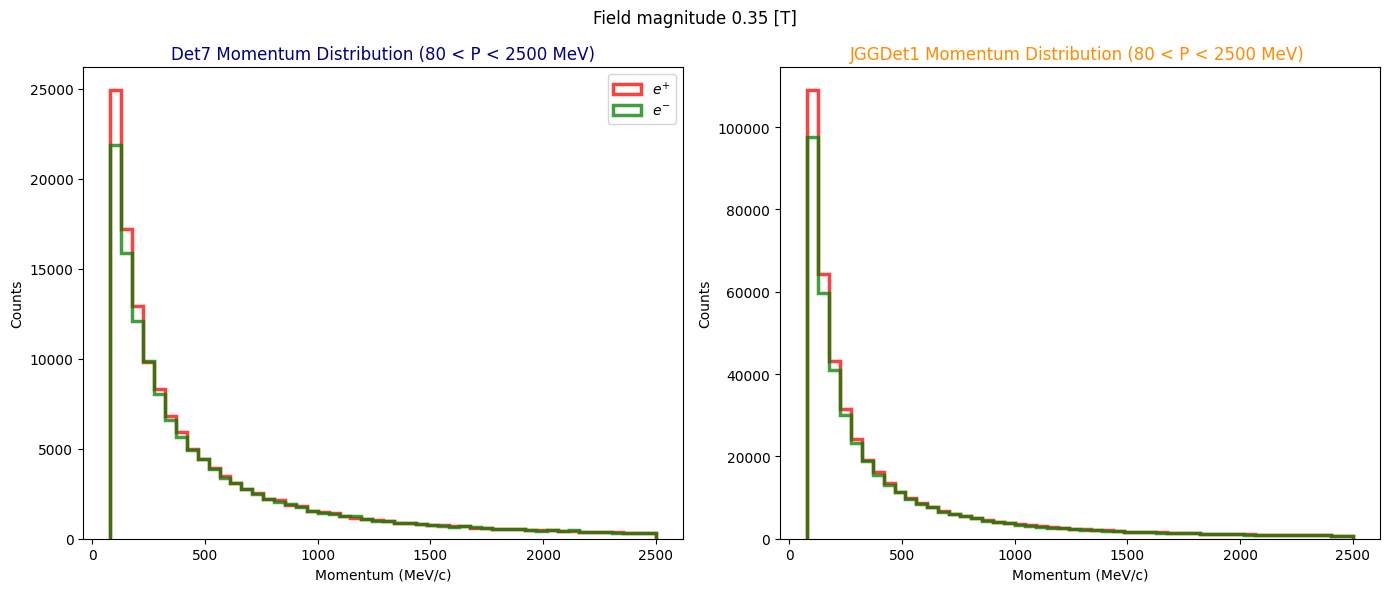

file /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/varying_fields/B0.30/merged_sim_arcs_beamline_simple_ opened
file adjusted
                   x           y             z         Px         Py  \
1          58.001999  123.898010  38904.808594   4.663996  -6.582988   
44        125.084442 -162.455032  38904.808594 -10.881021  -8.619164   
58         63.541183 -100.991226  38904.808594   4.288755  -3.000250   
97        -70.961685 -118.014656  38904.808594   6.446344   2.323975   
251       -31.196516   89.200912  38904.808594   3.235456   8.651301   
...              ...         ...           ...        ...        ...   
26930303 -208.045105 -138.049362  38904.808594   0.485440   2.625927   
26930435   82.672058  -58.960888  38904.808594  -6.035343 -12.146605   
26930507 -228.367371  160.250168  38904.808594  -5.981062   0.325662   
26930564  -31.819893  147.244324  38904.808594   5.286830  -3.402837   
26930594   70.419403  -10.881918  38904.808594  -4.854874   7.

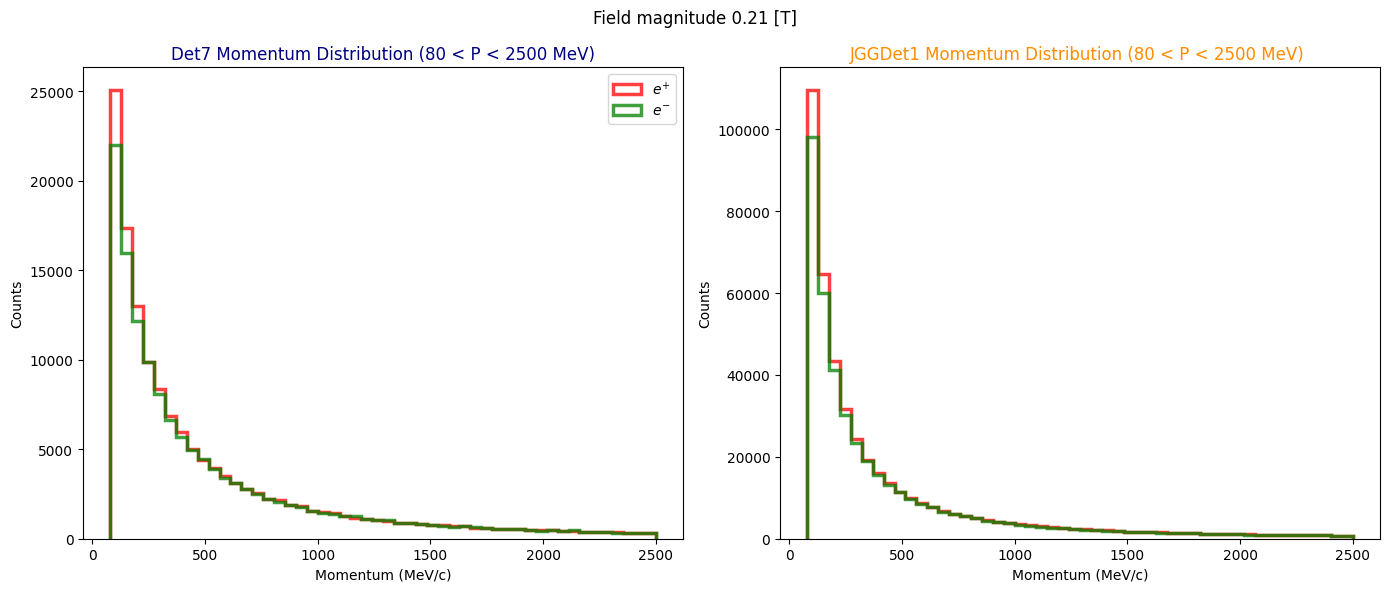

file /pnfs/lariat/persistent/users/lunich/BeamLineSimOutputs/pos60Amps/complete_sims/config08/merged_sim_arcs_beamline_simple_ opened
file adjusted
                   x           y             z          Px          Py  \
56        235.000000  -57.629261  38919.175781  -50.718777  -34.957878   
57        234.711975  -54.776016  38904.808594  -20.012545   -6.669620   
58        235.000000  -46.130756  38927.523438  -33.224628   -4.775531   
96       -232.145691  180.965118  38904.808594  -17.646709   -0.790533   
217       191.812012  106.070374  38904.808594  -36.272881   -1.029313   
...              ...         ...           ...         ...         ...   
57112775 -224.953949  122.335457  38904.808594  -95.262917   -2.090623   
57112807  -68.521072   73.201866  38904.808594   -3.986912   -5.294426   
57113081  -27.502459  -94.875740  38904.808594  -33.398750    6.375873   
57113123  146.385162 -158.894424  38904.808594   -1.784917    0.294980   
57113136  205.986572 -111.146149  3890

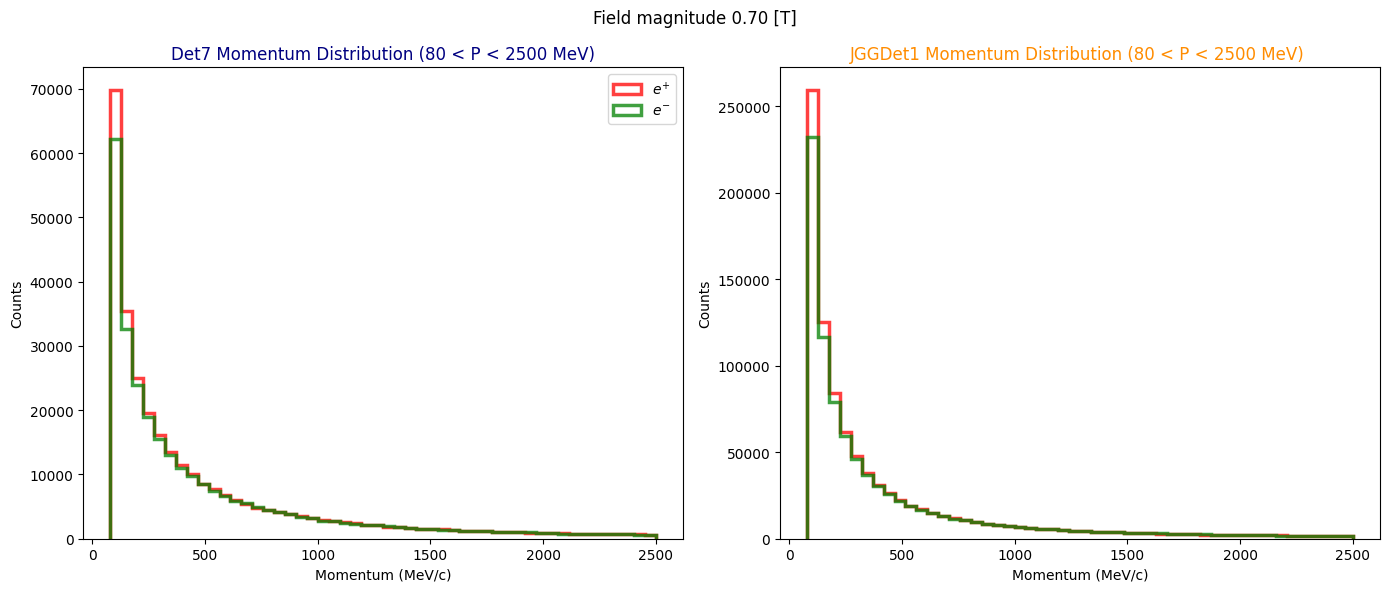

In [45]:
data = []
for f in fileslist[-3:]:
    data.append(analyze_file_with_cut(f, save = True) )

In [42]:
bs = [i[0]*0.70 for i in data]
means_det7 = [i[1] for i in data]
std_det7 = [i[1] for i in data]
means_Jgg = [i[3] for i in data]
std_Jgg = [i[4] for i in data]



In [43]:
errors_Det7 = [std_det7[i]/np.sqrt(n[i]) for i in range(len(std_det7))]
errors_Jgg = [std_Jgg[i]/np.sqrt(n[i]) for i in range(len(std_Jgg))]

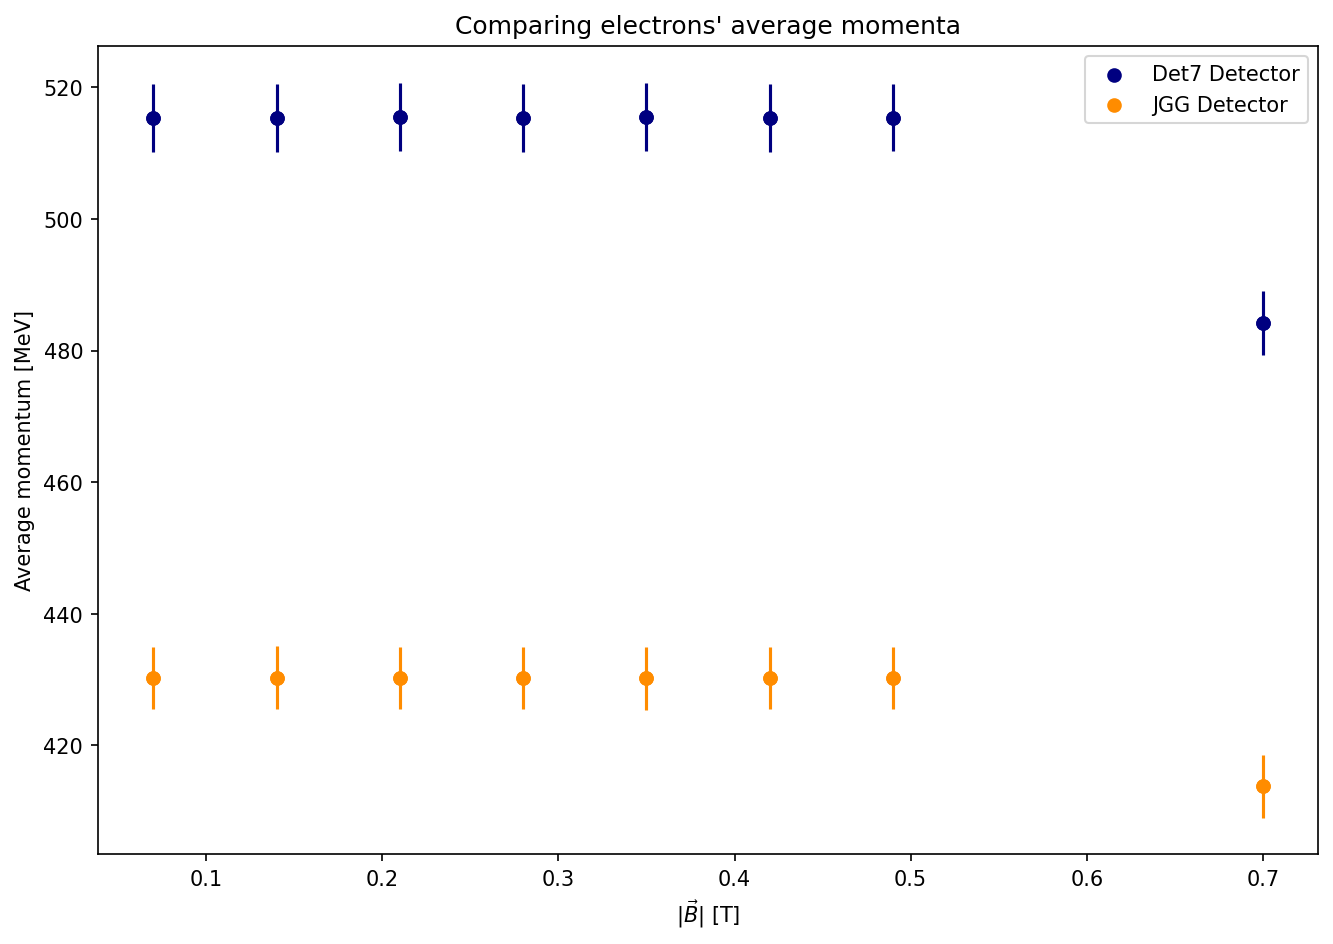

In [44]:
plt.figure(figsize = (10.5,7), dpi = 150)
plt.scatter (bs, means_det7, color = "navy", label = 'Det7 Detector')
plt.errorbar(bs, means_det7, errors_Det7,  color = "navy",fmt ='o')
plt.xlabel(r'$| \vec{B} |$ [T]')
plt.ylabel('Average momentum [MeV]')
plt.title("Comparing electrons' average momenta")
plt.scatter (bs, means_Jgg, color = "darkorange", label = 'JGG Detector')
plt.errorbar(bs, means_Jgg, errors_Jgg,  color = "darkorange", fmt ='o')
plt.legend()
plt.savefig('plots/Varying_fields.jpg')

aggiungere punto .7 T e punto in piú, contare il numero di file, Vedere la distribuzione fuori dal detector (JGG) senza condizione di triggering 
per la charge separation 0.3 tesla should be a nice field